# Inference
Notebook running through:
- Making predictions using trained model
- Outputting a new levees.gpkg
- Plotting some validation plots
- Testing vs original levees.gpkg for new/corrected levees

In [1]:
import geopandas as gpd
import segmentation_models_pytorch as smp
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from levee_hunter.levees_dataset import LeveesDataset
from levee_hunter.modeling.inference import get_preds_targets
from levee_hunter.plotting import plot
from levee_hunter.modeling.inference import infer
from levee_hunter.processing.levees_to_lines import *

/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/share/gpu5/ucapmgb/levee-hunter/levee_hunter/augmentations.py:16: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(
/share/gpu5/ucapmgb/levee-hunter/levee_hunter/augmentations.py:19: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(
/share/gpu5/ucapmgb/levee-hunter/levee_hunte

### Original levees file

In [2]:
# Load the original levees file
original_levees_gdf = gpd.read_file("/share/gpu5/ucapmgb/levee-hunter/data/raw/levees/levees.gpkg")

/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'levees.gpkg': 'System' (default), 'AlignmentLine'. Specify layer parameter to avoid this warning.
  result = read_func(


### Trained Model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
model = smp.UnetPlusPlus(
    encoder_name="resnet50", encoder_weights="imagenet", in_channels=1, classes=1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [5]:
# Load the trained model
# trained_model
model_path = "/share/gpu5/ucapmgb/levee-hunter/models/Unet-13_384_invert.pth"
# load saved model
model.load_state_dict(torch.load(model_path))
model.eval()

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

### Validation Dataset

In [6]:
dataset = LeveesDataset(
    images_dir='/share/gpu5/ucapmgb/levee-hunter/data/processed/_testing/13_384_invert/images',
    masks_dir='/share/gpu5/ucapmgb/levee-hunter/data/processed/_testing/13_384_invert/masks',
    transform=None,
    weighted=True,
    )

# Create DataLoader
val_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

### Predictions

In [7]:
# Get predictions
preds, targets = get_preds_targets(model=model, val_loader=val_loader, device=device)

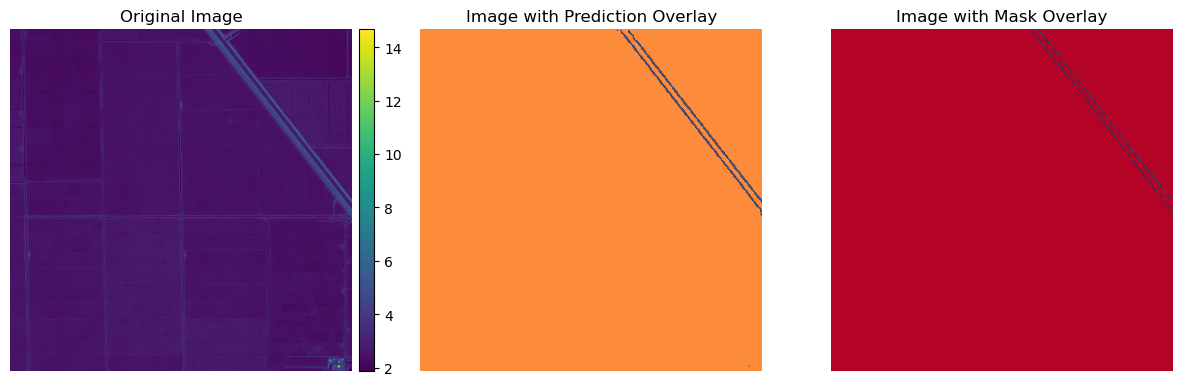

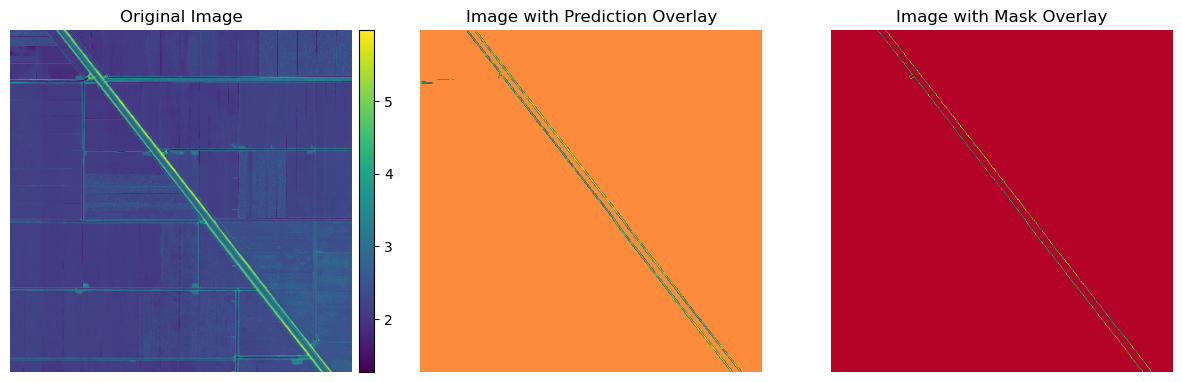

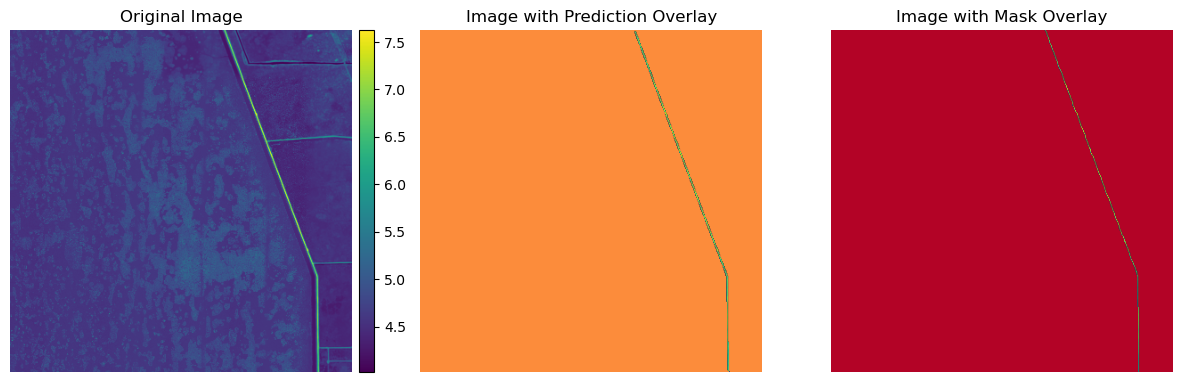

In [8]:
for ix in range(3):
    sample_image, sample_mask, *_ = dataset[ix]
    prediction = infer(model=model, image=sample_image, device=device, apply_sigmoid=True, threshold=0.5)
    
    plot(
        image=sample_image, 
        mask=sample_mask, 
        pred=prediction, 
        plot_types=['image', 'image_pred_overlay', 'image_mask_overlay'], 
        powernorm_threshold=30
        )

### Inference
- Skeletonize predictions
- Output images with new levees in them

In [9]:
# For testing a single image within the dataset
# gdf = single_prediction_to_lines(
#     pred=preds[5],
#     image_path=dataset.img_paths[5],
#     threshold=0.5,
#     crs="EPSG:4269",
#     min_length=2,
#     debug_plots=True
# )

In [10]:
# Converting all predictions to lines
predicted_levees_gdf = batch_predictions_to_lines(
    predictions=preds,
    image_paths=dataset.img_paths,
    threshold=0.5,
    min_length=2,
    debug_every_n=None,   # show debug plots every 10 tiles
)

Batch Extract Lines: 100%|██████████| 1316/1316 [20:22<00:00,  1.08it/s]


### Quantitative analysis
By setting a buffer of ~25m, we can find which levees/linesegments are close to the original levees and also find ones that aren't, thus showing new found levees, or outlining potential errors.

**Warning**: This will take a while...

In [11]:
matching, unmatched = find_matching_and_unmatched_predictions(predicted_levees_gdf, original_levees_gdf, buffer_meters=25)

Using buffer of 0.00022522522522522523 degrees (approximately 25 meters)


/share/gpu5/ucapmgb/levee-hunter/levee_hunter/processing/levees_to_lines.py:160: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_originals = original_gdf.geometry.buffer(buffer_value)
Matching predictions: 100%|██████████| 123095/123095 [2:51:52<00:00, 11.94it/s] 

Found 12394 predicted levees that match with originals
Found 110701 predicted levees that don't match with originals


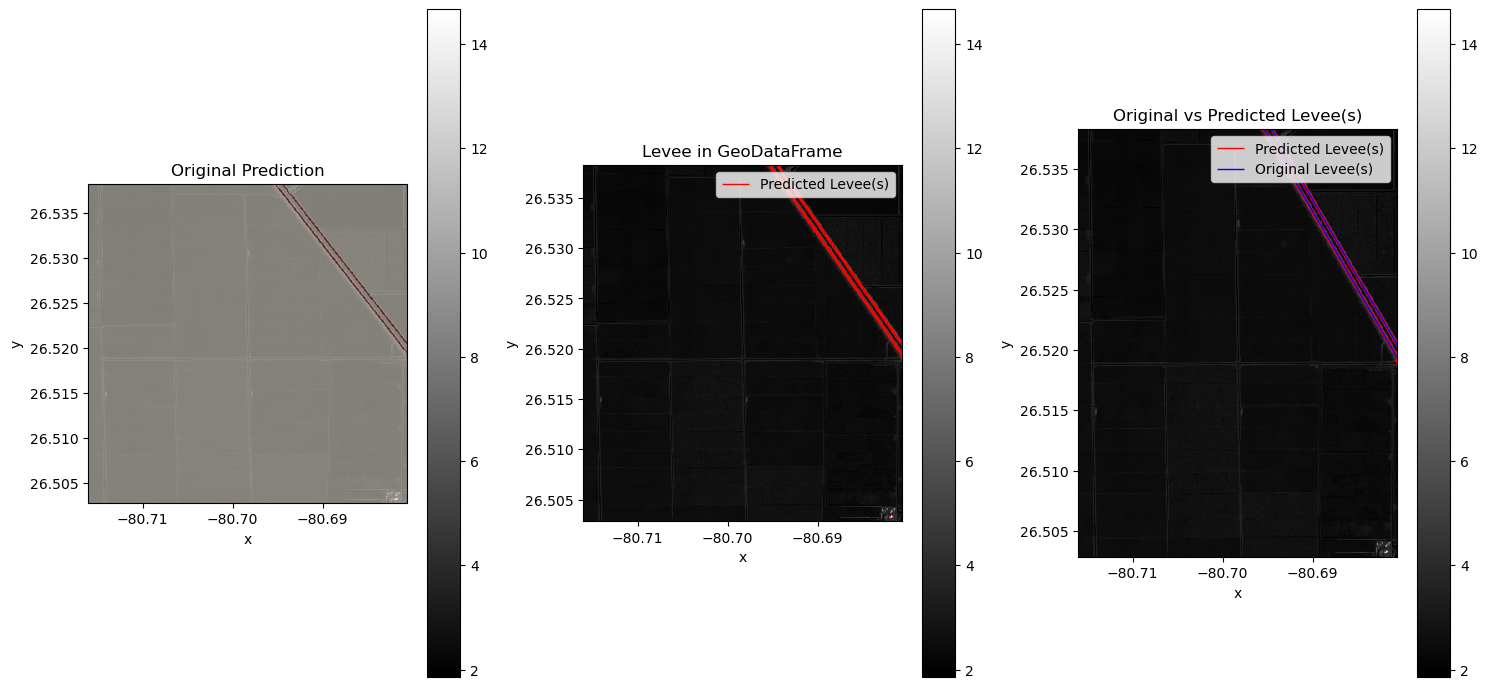

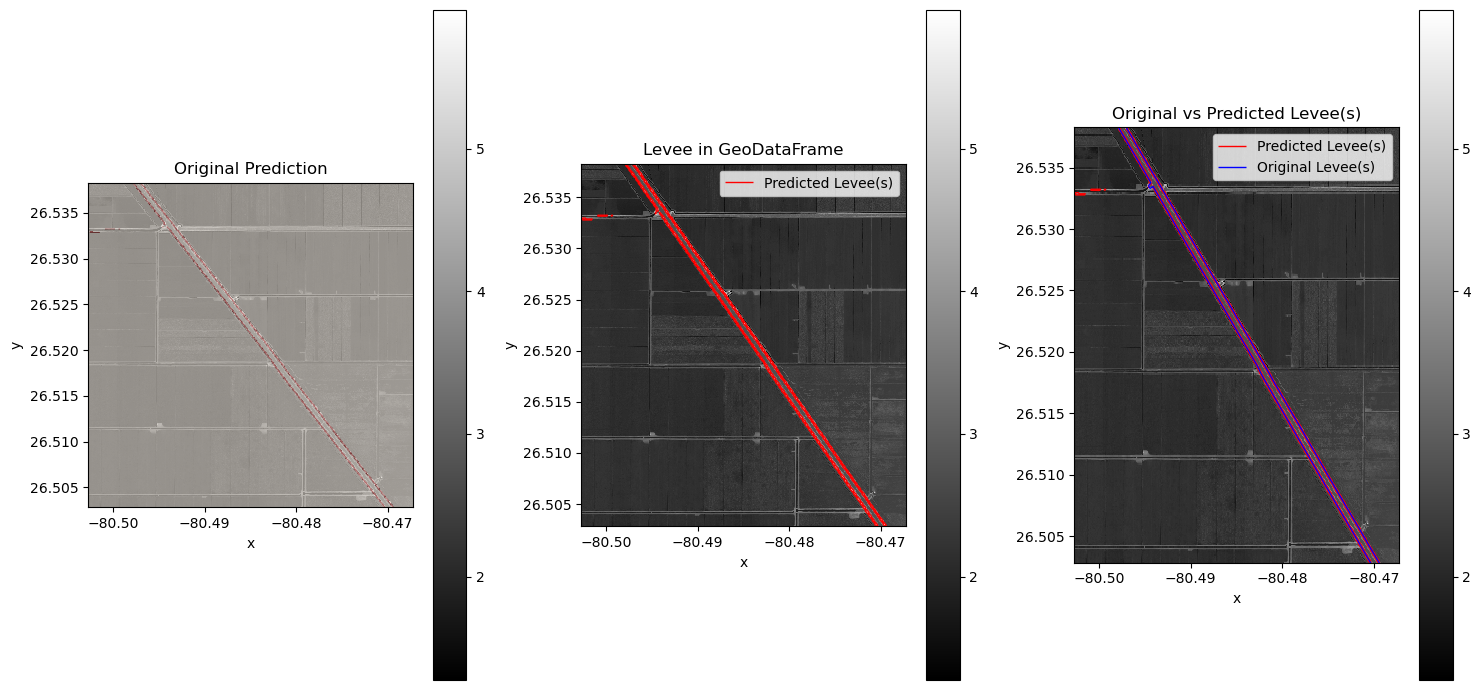

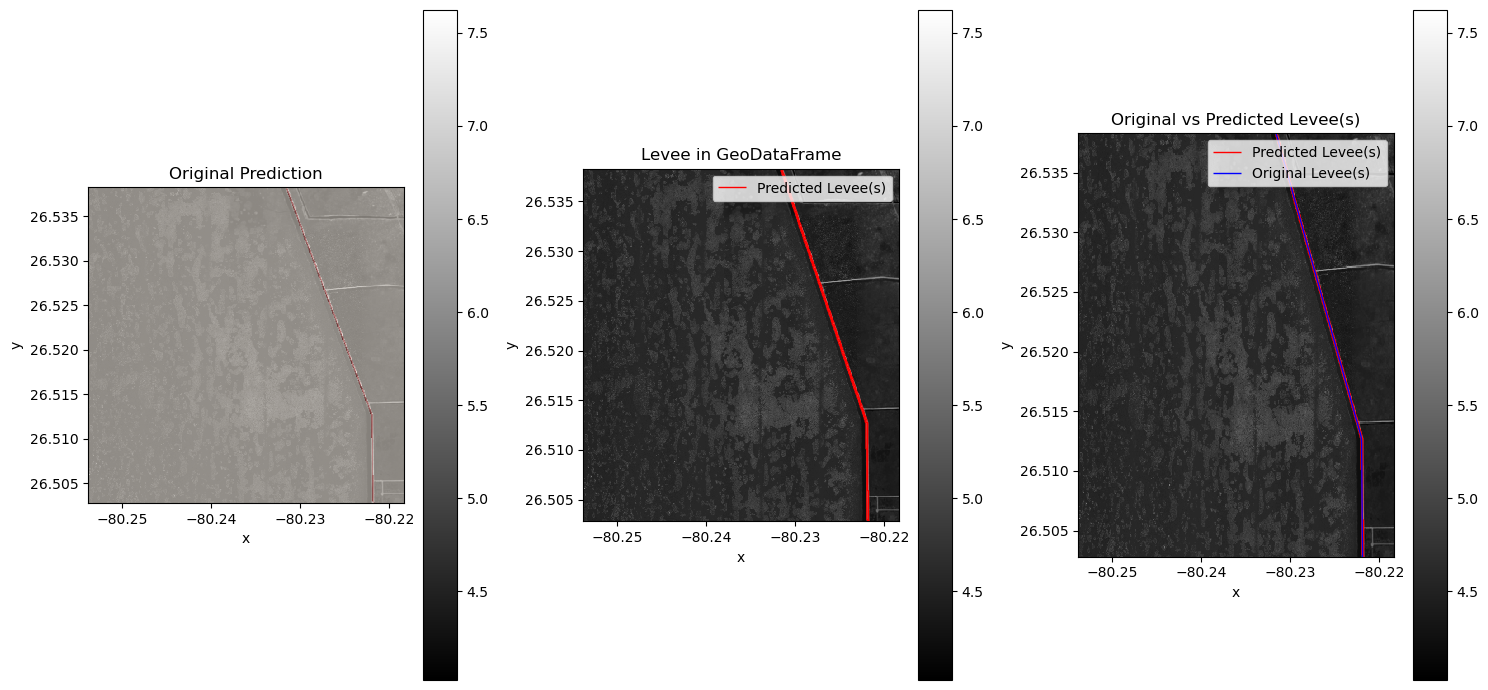

In [13]:
plot_matching(model, device, matching, dataset, predicted_levees_gdf, original_levees_gdf, n=3)